In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

import gpflow.multikernels as mk
import gpflow.multifeatures as mf

from gpflow.conditionals import conditional

In [2]:
X = np.random.rand(100)[:, None] * 10 - 5
G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))
Ptrue = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])
Y = np.matmul(G, Ptrue)
Y += np.random.randn(*Y.shape) * [0.2, 0.2, 0.2]

D = 1
M = 20
L = 2
P = 3
MAXITER = 200

In [3]:
pX = np.linspace(-6, 6, 100)[:, None]
def plot_model(m):
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)

## Shared Independent MOK & Shared Independent Features (SLOW CODE)

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [4]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kernel = mk.SharedIndependentMok(gpf.kernels.RBF(D) + gpf.kernels.Linear(D), P)
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [5]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature, q_mu=q_mu, q_sqrt=q_sqrt)

Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok


In [7]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 47.707372
  Number of iterations: 201
  Number of functions evaluations: 227


Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok


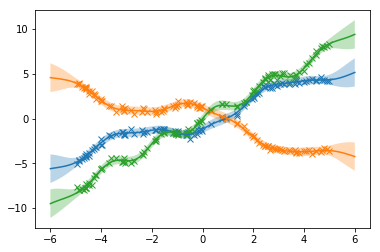

In [8]:
plot_model(m)

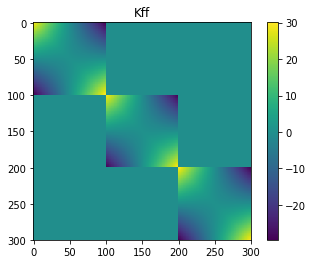

In [9]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
plt.imshow(np.reshape(K_trans, [100 * 3, 100*3]));
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, and the same kernel is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Shared Independent MOK & Shared Independent Features

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [4]:
kernel = mk.SharedIndependentMok(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), P)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [5]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Kuu: SharedIndependentMof - SharedIndependentMok
Kuf: SharedIndependentMof - SharedIndependentMok


In [6]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 56.281405
  Number of iterations: 201
  Number of functions evaluations: 233


Kuu: SharedIndependentMof - SharedIndependentMok
Kuf: SharedIndependentMof - SharedIndependentMok


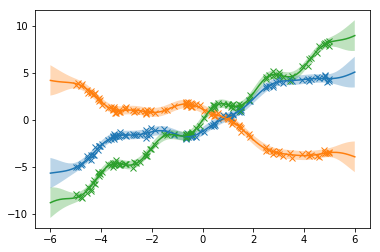

In [7]:
plot_model(m)

Again, same kernel used for each output dimension and the outputs are uncorrelated. In the `conditional`, however, we explicitly use the block-diagonal structure.

## Separate Independent MOK & Shared Independent Features (SLOW CODE)

In [9]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [10]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature, q_mu=q_mu, q_sqrt=q_sqrt)

Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok


In [11]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 77.408052
  Number of iterations: 201
  Number of functions evaluations: 218


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 77.408052
  Number of iterations: 201
  Number of functions evaluations: 218


Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok


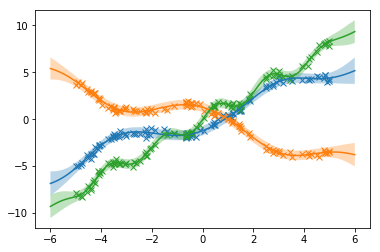

In [12]:
plot_model(m)

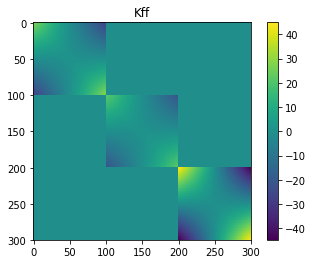

In [13]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
plt.imshow(np.reshape(K_trans, [100 * 3, 100*3]));
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, *but a different kernel* is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Separate Independent MOK & Shared Independent Features

In [14]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [15]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object


In [16]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 76.681200
  Number of iterations: 201
  Number of functions evaluations: 215


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 76.681200
  Number of iterations: 201
  Number of functions evaluations: 215


Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object


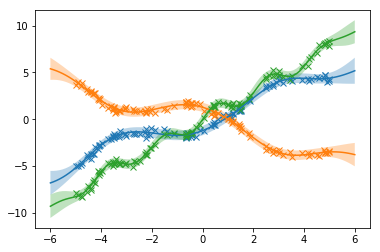

In [17]:
plot_model(m)

In [23]:
m.compute_log_likelihood()

-185.63755603244775

## Separate Independent Kernel & Separate Independent Features

In [18]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature_list = [gpf.features.InducingPoints(X[np.random.permutation(len(X))[:M],...].copy()) for _ in range(P)]
feature = mf.SeparateIndependentMof(feature_list)

In [19]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object


In [20]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 81.595252
  Number of iterations: 201
  Number of functions evaluations: 223


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 81.595252
  Number of iterations: 201
  Number of functions evaluations: 223


Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object


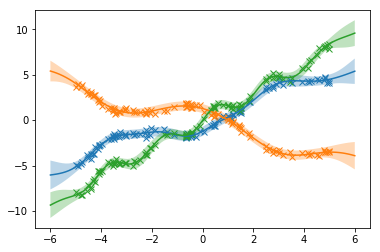

In [21]:
plot_model(m)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object


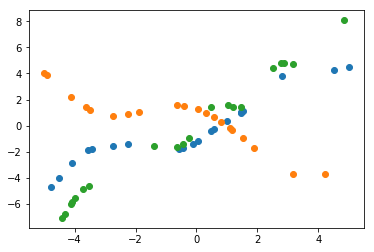

In [22]:
for i in range(len(m.feature.feat_list)):
    q_mu_unwhitenede, q_var_unwhitened = m.predict_f(m.feature.feat_list[i].Z.value)
    plt.plot(m.feature.feat_list[i].Z.value, q_mu_unwhitenede[:, [i]], "o")

This plot shows that we use different inducing *inputs* in each output dimension.

# Mixed Kernel

## 1. Mixed Kernel & Correlated features (SLOW)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
In this scenario we ignore the fact that observations are produced by mixing uncorrelated latent GPs. We directly model the correlated observations. This means that we place our inducing outputs in the $f$ space and end up with the following (large) correlation matrices.

- $ K_{uu} = M \times P \times M  \times P $
- $ K_{uf} = M \times P \times N \times P $

We'll have to use `fully_correlated_conditional` or `base_conditional` depending on the `full_cov`/`full_cov_output` args.

In [9]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L))
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [10]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


In [13]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=30000);

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: 27.138641
  Number of iterations: 12407
  Number of functions evaluations: 15001


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: 27.138641
  Number of iterations: 12407
  Number of functions evaluations: 15001


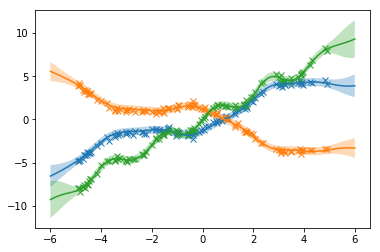

In [14]:
plot_model(m)

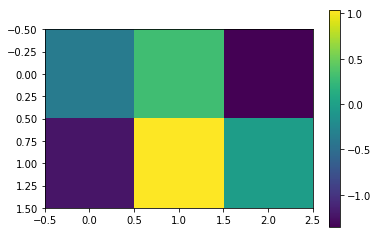

In [15]:
plt.imshow(m.kern.W.value.T)
plt.colorbar()

## 2. Mixed Kernel & Uncorrelated features (BETTER)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
In this scenario we assume that are inducing outputs live in the $g$ (i.e. $\mathbb{R}^L$) space.


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = M \times L \times N \times P $

We'll use `independent_latents_conditional`

In [4]:
q_mu = np.zeros((M, L))
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=Ptrue.T)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [5]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

In [6]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 8.789723
  Number of iterations: 1001
  Number of functions evaluations: 1168


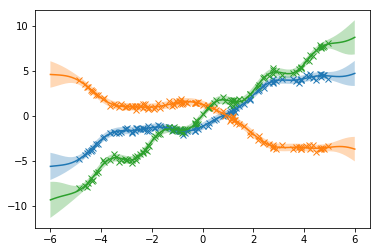

In [7]:
plot_model(m)

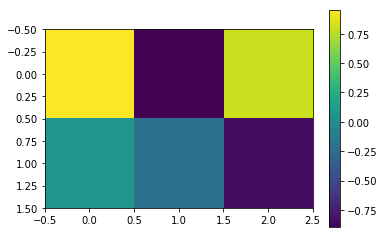

In [8]:
plt.imshow(m.kern.W.value.T)
plt.colorbar()

## 3. Mixed Kernel & Uncorrelated features (OPTIMAL)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W~\Sigma_g W^\top$


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

We'll use `base_conditional`

In [8]:
q_mu = np.zeros((M, L))
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L))
feature = mf.MixedKernelSharedMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [9]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

conditional: MixedKernelSharedMof, SeparateMixedMok
Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
Kuu: MixedKernelSharedMof, SeparateMixedMok
Kuf: MixedKernelSharedMof, SeparateMixedMok
base conditional


In [11]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=15000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -3.208232
  Number of iterations: 11504
  Number of functions evaluations: 12364


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -3.208232
  Number of iterations: 11504
  Number of functions evaluations: 12364


conditional: MixedKernelSharedMof, SeparateMixedMok
Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
Kuu: MixedKernelSharedMof, SeparateMixedMok
Kuf: MixedKernelSharedMof, SeparateMixedMok
base conditional


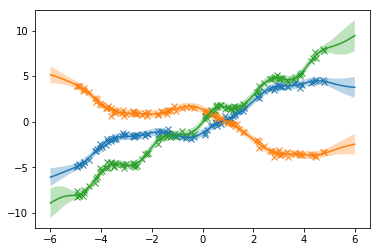

In [12]:
plot_model(m)